In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
ticker = 'AAPL'
df =yf.download(ticker,'2021-01-01')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7396\2513434916.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df =yf.download(ticker,'2021-01-01')
[*********************100%***********************]  1 of 1 completed


In [6]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-01-04,126.096588,130.189048,123.514437,130.101356,143301900
2021-01-05,127.655617,128.366937,125.141673,125.589902,97664900
2021-01-06,123.358536,127.694603,123.144167,124.449862,155088000
2021-01-07,127.567871,128.259699,124.586223,125.073421,109578200
2021-01-08,128.668976,129.234127,126.895568,129.039236,105158200
...,...,...,...,...,...
2025-10-24,262.820007,264.130005,259.179993,261.190002,38253700
2025-10-27,268.809998,269.119995,264.649994,264.880005,44888200


<Axes: xlabel='Date'>

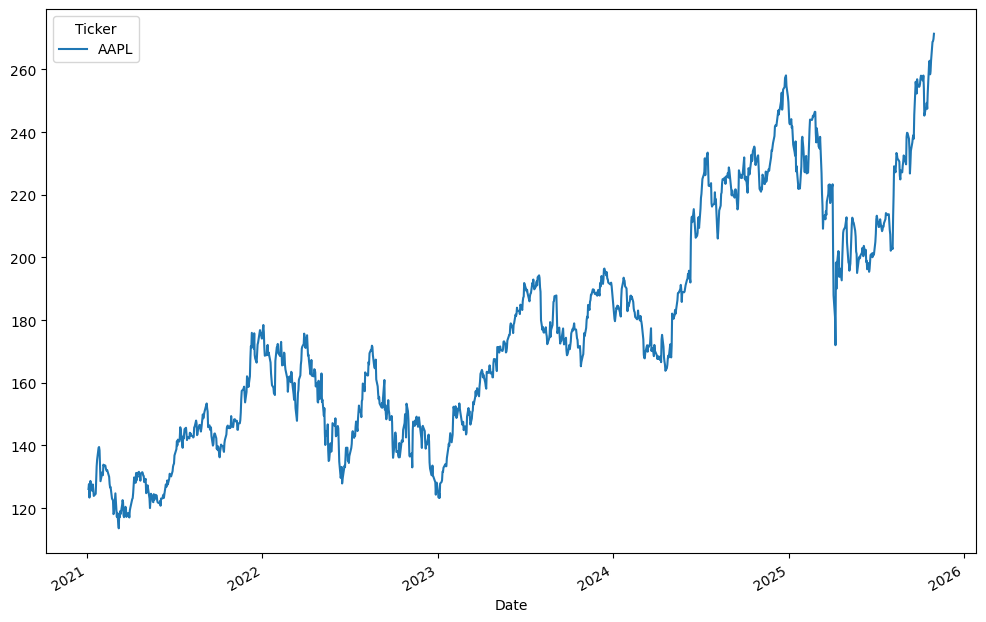

In [8]:
df.Close.plot(figsize=(12,8))

In [9]:
#preprocessing

In [10]:
scaler=StandardScaler()

In [12]:
df['Close']=scaler.fit_transform(df['Close'])

In [15]:
df.Close

Ticker,AAPL
Date,
2021-01-04,-1.373351
2021-01-05,-1.330822
2021-01-06,-1.448044
2021-01-07,-1.333216
2021-01-08,-1.303179
...,...
2025-10-24,2.356369
2025-10-27,2.519771
2025-10-28,2.524954


In [19]:
#Number of days for training
seq_length=30
data=[]

for i in range(len(df)-seq_length):
    data.append(df.Close[i:i+seq_length])
data=np.array(data)

In [20]:
data

array([[[-1.37335145],
        [-1.33082223],
        [-1.44804362],
        ...,
        [-1.21594141],
        [-1.20955324],
        [-1.26758462]],

       [[-1.33082223],
        [-1.44804362],
        [-1.33321587],
        ...,
        [-1.20955324],
        [-1.26758462],
        [-1.33014437]],

       [[-1.44804362],
        [-1.33321587],
        [-1.3031785 ],
        ...,
        [-1.26758462],
        [-1.33014437],
        [-1.36022483]],

       ...,

       [[ 1.68338771],
        [ 1.70630265],
        [ 1.6760226 ],
        ...,
        [ 2.26798305],
        [ 2.35636856],
        [ 2.51977134]],

       [[ 1.70630265],
        [ 1.6760226 ],
        [ 1.88389078],
        ...,
        [ 2.35636856],
        [ 2.51977134],
        [ 2.52495448]],

       [[ 1.6760226 ],
        [ 1.88389078],
        [ 2.17250547],
        ...,
        [ 2.51977134],
        [ 2.52495448],
        [ 2.54405032]]], shape=(1183, 30, 1))

In [62]:
trainsize=int(0.8*len(data))
x_train=torch.from_numpy(data[:trainsize,:-1,:]).type(torch.Tensor).to(device)
y_train=torch.from_numpy(data[:trainsize,-1,:]).type(torch.Tensor).to(device)
x_test=torch.from_numpy(data[trainsize:,:-1,:]).type(torch.Tensor).to(device)
y_test=torch.from_numpy(data[trainsize:,-1,:]).type(torch.Tensor).to(device)

In [63]:
class PredictionModel(nn.Module):

    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(PredictionModel,self).__init__()
        self.num_layers=num_layers
        self.hidden_dim=hidden_dim

        self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True,dropout=0.2)
        self.fc=nn.Linear(hidden_dim,output_dim)

    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)

        out,(hn,cn)=self.lstm(x,(h0.detach(),c0.detach()))
        out=self.fc(out[:,-1,:])

        return out

In [64]:
model=PredictionModel(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1).to(device)

In [65]:
criterion=nn.MSELoss()
optimiser=optim.Adam(model.parameters(),lr=0.01)

In [66]:
num_epochs =200
for i in range(num_epochs):
    y_train_pred=model(x_train)
    
    loss=criterion(y_train_pred,y_train)

    if i % 25 == 0:
        print(i,loss.item())
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

0 0.6946889162063599
25 0.01721762865781784
50 0.01300744991749525
75 0.010912837460637093
100 0.01015761960297823
125 0.009171654470264912
150 0.008701208978891373
175 0.008161305449903011


In [67]:
model.eval()
y_test_pred=model(x_test)

y_train_pred=scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train=scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred=scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test=scaler.inverse_transform(y_test.detach().cpu().numpy())

In [68]:
train_rmse=root_mean_squared_error(y_train[:,0],y_train_pred[:,0])
test_rmse=root_mean_squared_error(y_test[:,0],y_test_pred[:,0])

In [69]:
train_rmse

3.196110248565674

In [70]:
test_rmse

8.945110321044922

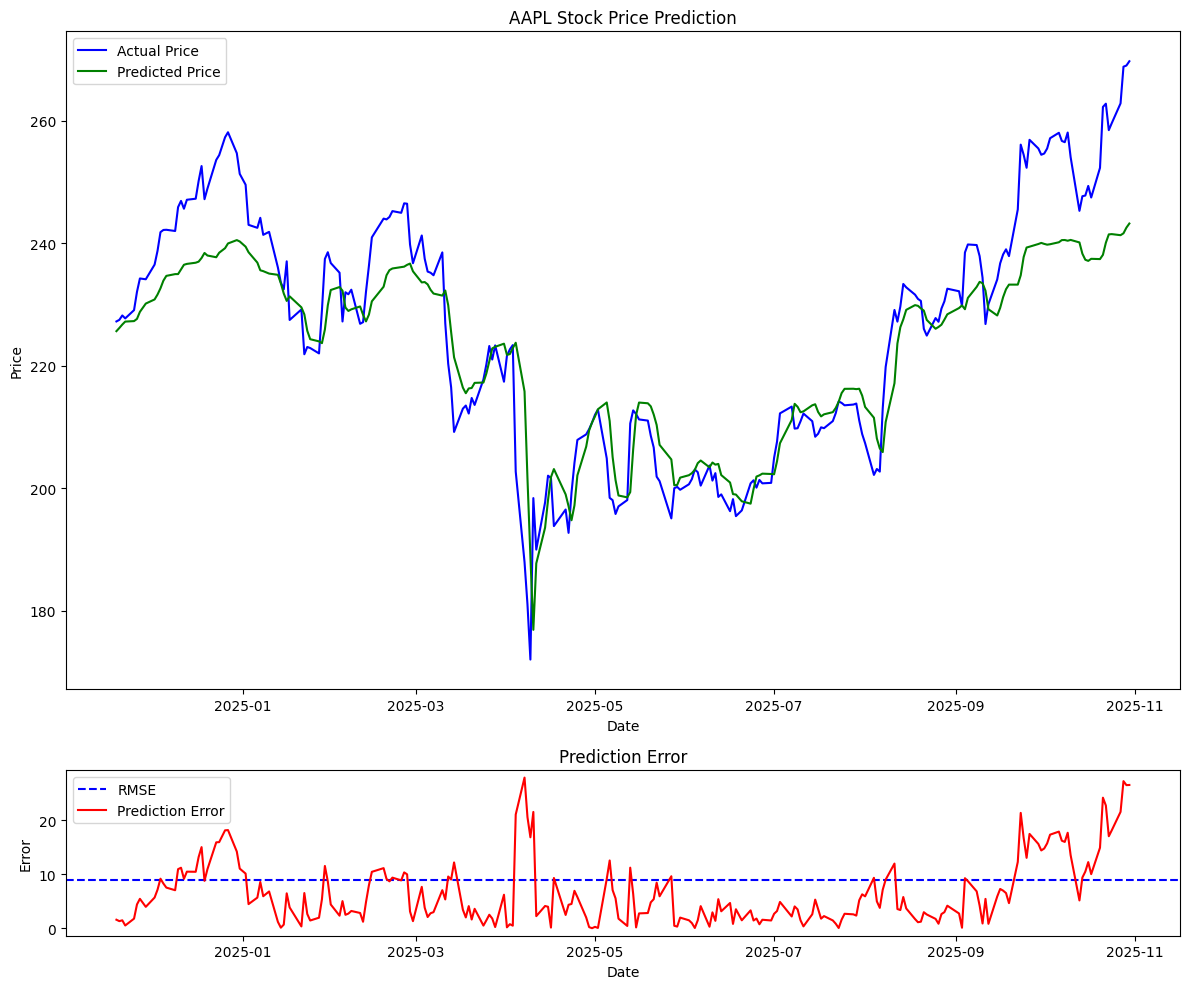

In [75]:
fig=plt.figure(figsize=(12,10))

gs=fig.add_gridspec(4,1)

ax1=fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index,y_test,color='blue',label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index,y_test_pred,color='green',label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2=fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse,color='blue',linestyle='--',label='RMSE')
ax2.plot(df[-len(y_test):].index,abs(y_test-y_test_pred),'r',label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()